<img src="logoucm.png" style="height: 300px">


# **PRÁCTICA FINAL MACHINE LEARNING. PARTE 2**

##### Por Sofía Canela García-Arias, Berta Corriols Barrio & Víctor Panadero Gómez

In [74]:
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns    #visualización
import matplotlib.pyplot as plt   #visualización
import scipy
import math
%matplotlib inline     
sns.set(color_codes=True)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import RobustScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report

import statsmodels.api as sm

from sklearn.metrics import precision_recall_curve, auc

In [75]:
df_fin = pd.read_csv("preprocesado.csv", sep = '\t')
df_fin

,Unnamed: 0,C_MNTH,C_WDAY,C_HOUR,C_VEHS,C_CONF,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_TYPE,V_YEAR,P_SEX,P_AGE,P_PSN,P_SAFE,P_USER,C_SEV
0,0,4,5,16,3,21,2,5,5,1,8,1,1998,1,51,11,2,1,0
1,1,8,1,19,2,35,1,1,1,1,18,1,2005,0,40,11,2,1,0
2,2,3,5,7,2,21,1,3,2,1,18,1,2006,0,53,11,2,1,0
3,3,6,5,18,1,6,1,1,1,1,18,1,2000,1,9,21,2,2,0
4,4,9,4,9,1,3,100,3,2,3,18,1,2001,0,25,11,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172681,172681,12,7,11,3,35,2,1,100,1,3,7,2014,0,35,11,2,1,1
172682,172682,12,7,1,1,4,100,6,1,1,18,1,2011,0,30,11,2,1,1
172683,172683,12,7,2,1,100,1,1,1,1,18,8,2013,1,37,11,2,1,1
172684,172684,8,5,22,1,6,1,1,4,100,18,22,2000,1,67,12,1,1,1


In [76]:
#Eliminamos la primera columna
df_fin =df_fin.drop('Unnamed: 0', axis = 1)

## **3. Train-Test split**

In [77]:
X = df_fin.drop(['C_SEV'], axis = 1) 
y = df_fin['C_SEV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## **4. Escalado de los datos**

En este apartado, se realizará un escalado de los datos por sí resultase necesario para la implementación de algún algoritmo. De esta manera, dispondremos de unos datos que no estarán escalados y de otros que sí lo están. Usaremos unos u otros en función de nuestras necesidaddes.

In [78]:
robust_scaler = RobustScaler()
X_train_scaled = robust_scaler.fit_transform(X_train)
X_test_scaled = robust_scaler.fit_transform(X_test)

#Los guardamos en un data frame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns.tolist())
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns.tolist())

**NOTAS**: 
- Ahora que hemos escalado X_train, podremos implementar los modelos que requieran de escalado usando X_train_scaled. (En los que no lo requieran, realmente, también podemos).
- Nótese que no hace falta reescalar y_train. Que la variable objetivo no esté escalada, no afecta al rendimiento de los modelos.
- **¡Estamos reescalando variables categóricas con codificación entera!** Si finalmente usamos el reescalado de datos, deberemos tener cuidado con las interpretaciones posteriores, etc.

## **5. Modelos**

En los sucesivos apartados iremos implementando modelos que nos permitan llevar a cabo **nuestro objetivo**: intentar predecir si diferentes accidentes son causa o no de fallecimiento. En otras palabras: tenemos un problema de **clasificación binaria**. Nuestra variable objetivo, como ya hemos detallado, es ***C_SEV*** y toma valores 0 y 1.

- **NOTA 1**: Este objetivo podría estar muy relacionado con las tareas de las **instituciones públicas**: campañas de concienciación para prevenir accidentes, pero sobre todo, o en última instancia, **para prevenir muertes**; (véanse campañas para el uso del cinturón de seguridad).

- **NOTA 2**: Por supuesto, se podrían plantear otros objetivos. Perseguimos el ya descrito porque se indica en la tarea que, como mínimo, se debe atacar este objetivo. Si da tiempo, se atacarán otros también.

Dicho esto: una vez implementados diferentes modelos, es importante, tal y como se indica en el enunciado de la práctica, comparar los mismos para la posterior selección del que consideremos que tiene mejor rendimiento. Para ello, es importante definir/escoger una métrica que consideremos adecuada y que nos permita evaluar los diferentes rendimientos de igual manera, para poder posteriormente comparar.

Así, la siguiente pregunta es: **¿Qué métrica podemos emplear?**

Pues bien, teniendo en cuenta que estamos ante un problema de clasificación binaria - que se puede ver como clasificación de positivos (hay fallecidos: '1') y negativos (no hay fallecidos: '0') - una buena métrica podría ser considerada el **RECALL**. Pero, **¿por qué esta y no otra?** Bien: ya hemos dicho que el problema que estamos abordando podría verse desde el punto de vista de las **instituciones públicas**. El objetivo final de éstas será **tratar de reducir los fallecimientos a causa de accidentes de tráfico. Por encima de cualquier cosa**. Es decir, es **importante predecir bien los accidentes que causan fallecimiento, aunque eso implique predecir alguno que no cause fallecimiento como uno que sí lo haga**. Por esta razón, consideramos que el **recall es una buena opción**. 

- El recall se centra en la capacidad del modelo para identificar correctamente los casos positivos (fallecimientos en este caso). Al maximizar el recall, se asegura que se capturan la mayoría de los casos positivos, lo que permite tomar acciones preventivas y asignar recursos adecuados para minimizar los fallecimientos. Dado que las instituciones públicas priorizan evitar la pérdida de vidas, el recall es la métrica más relevante para evaluar el desempeño del modelo en este caso.
- Se calcula como el cociente entre el número de verdaderos positivos (TP) y la suma de los verdaderos positivos y los falsos negativos (FN):

                                                Recall = TP / (TP + FN)

### **5.1. KNN**

El primer modelo que entrenaremos será **K-NearestNeighbours**. Antes de empezar, haremos algunas anotaciones:

1. Nuestra idea primera era poder optimizar **dos hiperparámetros**: el primero de ellos sería ***n***, que representa el número de primeros vecinos. El segundo sería ***p***, que representaría la distancia. Así, haciendo GridSearchCV, trataríamos de hallar los hiperparámetros óptimos que nos diesen el mejor modelo. 

2. El número de primeros vecinos hemos dedicido limitarlo a un máximo de 15. Por su parte, para elegir la distancia, habíamos decidido buscar la ***p*** en la rejilla determinada por **np.linspace(1, 3, 21)**.

3. Una buena manera de buscar el mejor modelo hubiese sido hacer cv=LOO, es decir, implementar la **técnica del LeaveOneOut**: un k-fold en la que el tamaño de cada subconjunto es una observación. Dado el tamaño de nuestro set de entrenamiento, esto es **computacionalmente inviable** **(ADEMÄS DE QUE NOS DA MEMORY ERROR, CLARO)**. Tras está conclusión, pensamos en hacer **cv=3**, que se corresponde con una Validación Cruzada 3-fold. La conclusión es que sigue siendo **computacionalmente muy pesada**: nótese que habría que entrenar 3 modelos por cada iteración x 15 valores para la n x 21 valores para la p, lo que hace un total de 3x15x21 modelos a entrenar a una media de unos 2 minutos por modelo... Se va de las manos. 

    Finalmente, por los **motivos computacionales** a los que estamos refiriéndonos, decidimos hacer una **validación cruzada simple** con la **búsqueda de un único hiperparámetro: el número de vecinos óptimo**. De esta manera, tenemos que entrenar tan sólo 15 modelos (que ya son, por otra parte). Si los resultados no son aceptables, se intentará computar una validación cruzada 3-fold para este mismo parámetro, aunque el coste computacional sea alto.

**CÓDIGO PARA DOS HIPERPARÁMETROS CON LOO. (Para 3-fold sería el mismo poniendo cv=3 en GridSearch).**

In [33]:
#from sklearn.model_selection import LeaveOneOut 

#knn = KNeighborsClassifier()

#ps = np.linspace(1, 3, 21) 
#ns = list(range(1,16)) 
#h_parameters = {'p':ps, 'n_neighbors':ns}

#scoring = make_scorer(recall_score)
#loo = LeaveOneOut()
 
#cv = GridSearchCV(knn, h_parameters, cv=loo, n_jobs=-1, scoring=scoring)
#cv.fit(X_train_scaled_df, y_train)

Ahora sí, aplicamos **KNN** teniendo en cuenta lo detallado en los puntos previos. (Como ya hemos adelantado previamente, utilizaremos el recall como función score):

In [6]:
from sklearn.model_selection import LeaveOneOut 
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, recall_score


knn = KNeighborsClassifier() 
ns = list(range(1,16))
h_parameters = {'n_neighbors':ns} 
scoring = make_scorer(recall_score)
cv_simple = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

cv = GridSearchCV(knn, h_parameters, cv=cv_simple, scoring=scoring) 
cv.fit(X_train_scaled_df, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=42, test_size=0.2, train_size=None),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15]},
             scoring=make_scorer(recall_score))

In [7]:
#Sacamos el hiperparámetro n que maximiza el score:
cv.best_estimator_

KNeighborsClassifier(n_neighbors=9)

In [8]:
#Sacamos los resultados de CV para entender la gráfica posterior:
cv.cv_results_

{'mean_fit_time': array([0.04944229, 0.07815981, 0.07817006, 0.04686618, 0.06248689,
        0.03124571, 0.06248784, 0.04691267, 0.03123856, 0.04686713,
        0.04686999, 0.03124452, 0.03125978, 0.03125548, 0.03124809]),
 'std_fit_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'mean_score_time': array([  60.46069884,   77.58832049,   79.67534137,  107.54092002,
         115.67363596,  120.74715209,  112.38401556, 1275.51437402,
          60.9321382 ,   61.32988191,   61.06554317,   62.65649581,
          65.96304989,   63.97722125,   65.57609415]),
 'std_score_time': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'param_n_neighbors': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 1},
  

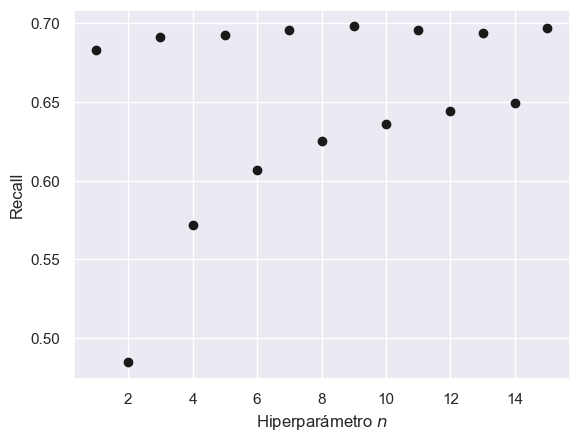

In [9]:
plt.plot(ns, cv.cv_results_['mean_test_score'], 'ok')
plt.xlabel('Hiperparámetro $n$')
plt.ylabel('Recall')
plt.grid(True)

En los outputs previos hemos obtenido, respectivamente por orden:

1. El hiperparámetro óptimo.
2. Un resumen del proceso de CV.
3. Una gráfica que ilustra el procedimiento de CV Simple. En ella, se puede ver que el mejor valor para nuestra scoring function se obtiene para el hiperparámetro n = Nº vecinos = 9.

Una vez ilustrado de manera gráfica lo que estamos haciendo en el ajuste del modelo, y teniendo en cuenta que el resultado de hacer CV nos dice que nuestro hiperparámtero óptimo es ***n=9***, vamos a ajustar el modelo con nuestro set de entrenamiento:

In [10]:
#fit para train
knn = KNeighborsClassifier(n_neighbors=9) 
knn.fit(X_train_scaled_df, y_train)

#predict para test 
y_pred = knn.predict(X_test_scaled_df)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


A continuación, sacamos la matriz de confusión. Ya hemos dicho en varias ocasiones que la métrica de evaluación que más nos interesará y que utilizaremos para comparar modelos será el **recall para accidentes con fallecimientos ('1')**. No obstante, sacamos otras métricas para tener también otras referencias de cómo de bien funciona nuestro modelo (aunque no las vayamos a tener en cuenta a la hora de seleccionar el modelo óptimo).

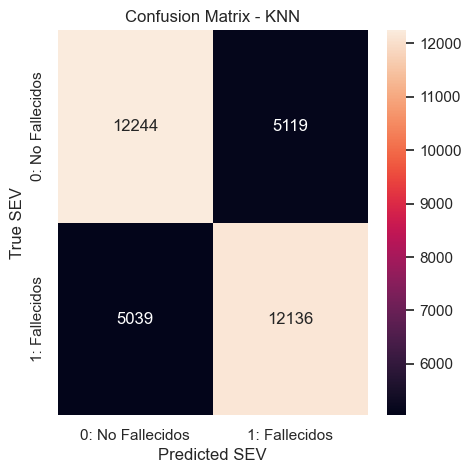

              precision    recall  f1-score   support

           0       0.71      0.71      0.71     17363
           1       0.70      0.71      0.70     17175

    accuracy                           0.71     34538
   macro avg       0.71      0.71      0.71     34538
weighted avg       0.71      0.71      0.71     34538



In [11]:
conf_matrix_KNN = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
labels = ['0: No Fallecidos','1: Fallecidos']
sns.heatmap(conf_matrix_KNN, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion Matrix - KNN")
plt.ylabel('True SEV')
plt.xlabel('Predicted SEV')
plt.show()
print (classification_report(y_test, y_pred))

Para comenzar a comentar los resultados, destacamos **la métrica que nos interesa**: **OBTENEMOS UN RECALL PARA '1' DE 0.71.** Creemos que es un resultado aceptable teniendo en cuenta que no hemos podido hacer una búsqueda demasiado exhaustiva de hiperparámetro/s óptimo/s. 

Además, si atendemos a otras métricas para hacernos una idea de como funcionaría nuestro modelo si nuestros objetivos fuesen otros, vemos que obtenemos exactamente el mismo valor, con una accuracy de 0.71 y una precisión de 0.71 también. 

**RECORDAMOS**: 
- La **exactitud (accuracy)** es una medida de cuántas de las muestras totales se clasificaron correctamente, ya sean positivas o negativas. Es una métrica global que considera tanto los verdaderos positivos como los verdaderos negativos. Es **útil cuando todas las clases tienen una importancia similar** y no hay un desequilibrio significativo entre las clases. En este sentido y teniendo en cuenta lo que hemos explicado, ya sabemos que no será una métrica muy significativa para nosotros porque nuestras clases **no tienen la misma importancia**. Igualmente, vemos que no es mala.

                                       Accuracy = (TP + TN) / (TP + TN + FP + FN)

A continuación, utilizamos el modelo de regresión logística:

### **5.2. Regresión logística**

En segundo lugar, implementamos un modelo de regresión logística. 

Comenzaremos ajustando el modelo con todas las variables y analizaremos posteriormente el resumen de salida:

In [15]:
# import statsmodels.api as sm

X_m1 = sm.add_constant(X_train_scaled_df)
y_train_df = pd.DataFrame(y_train)
y_train_df = y_train_df.reset_index(drop=True)

logit1 = sm.Logit(y_train_df, X_m1)
results1 = logit1.fit() 

results1.summary()

Optimization terminated successfully.
         Current function value: 0.658440
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  C_SEV   No. Observations:               138148
Model:                          Logit   Df Residuals:                   138130
Method:                           MLE   Df Model:                           17
Date:                Wed, 07 Jun 2023   Pseudo R-squ.:                 0.05007
Time:                        01:18:57   Log-Likelihood:                -90962.
converged:                       True   LL-Null:                       -95757.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0978      0.009     11.201      0.000       0.081       0.115
C_MNTH         0.0914      0.010      9.310      0.000       0.072       0.111
C_WDAY         0.2725      0.011     23.815      0.000       0.250       0.295
C_HOUR        -0.1853      0.009    -21.275      0.000      -0.202      -0.168
C_VEHS         0.0273      0.002     11.562      0.000       0.023       0.032
C_CONF        -0.0574      0.008     -7.334      0.000      -0.073      -0.042
C_RCFG      -2.07e-05      0.000     -0.056      0.955      -0.001       0.001
C_WTHR         0.0033      0.001      3.063      0.002       0.001       0.005
C_RSUR         0.0004      0.000      1.236      0.217      -0.000       0.001
C_RALN         0.0077      0.001      7.299      0.000       0.006       0.010
C_TRAF         0.4139      0.009     47.297      0.000       0.397       0.431
V_TYPE         0.0103      0.001     12.761      0.000       0.009       0.012
V_YEAR        -0.1059      0.007    -14.770      0.000      -0.120      -0.092
P_SEX          0.5030      0.012     43.183      0.000       0.480       0.526
P_AGE          0.2613      0.009     29.886      0.000       0.244       0.278
P_PSN          0.0293      0.001     24.766      0.000       0.027       0.032
P_SAFE         0.0056      0.001     10.513      0.000       0.005       0.007
P_USER         0.1445      0.008     18.056      0.000       0.129       0.160
==============================================================================
"""

Se puede ver en el output previo que tenemos **dos p-valores mayores que 0.01, 0.05 y 0.1**: son los correspondientes a las variables ***C_RCFG*** y ***C_RSUR***. Esto nos dice que no se puede rechazar la hipótesis nula de que estas variables no sean significativas. Procedemos a su eliminación:

In [16]:
X_m2 = X_m1.drop(columns=['C_RCFG', 'C_RSUR'])
logit2 = sm.Logit(y_train_df, X_m2)
results2 = logit2.fit() 

results2.summary()

Optimization terminated successfully.
         Current function value: 0.658445
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  C_SEV   No. Observations:               138148
Model:                          Logit   Df Residuals:                   138132
Method:                           MLE   Df Model:                           15
Date:                Wed, 07 Jun 2023   Pseudo R-squ.:                 0.05006
Time:                        01:19:04   Log-Likelihood:                -90963.
converged:                       True   LL-Null:                       -95757.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0995      0.009     11.599      0.000       0.083       0.116
C_MNTH         0.0909      0.010      9.273      0.000       0.072       0.110
C_WDAY         0.2722      0.011     23.796      0.000       0.250       0.295
C_HOUR        -0.1854      0.009    -21.289      0.000      -0.202      -0.168
C_VEHS         0.0274      0.002     11.606      0.000       0.023       0.032
C_CONF        -0.0577      0.008     -7.394      0.000      -0.073      -0.042
C_WTHR         0.0034      0.001      3.184      0.001       0.001       0.006
C_RALN         0.0077      0.001      7.294      0.000       0.006       0.010
C_TRAF         0.4144      0.009     47.489      0.000       0.397       0.431
V_TYPE         0.0103      0.001     12.759      0.000       0.009       0.012
V_YEAR        -0.1057      0.007    -14.752      0.000      -0.120      -0.092
P_SEX          0.5031      0.012     43.187      0.000       0.480       0.526
P_AGE          0.2611      0.009     29.874      0.000       0.244       0.278
P_PSN          0.0294      0.001     24.826      0.000       0.027       0.032
P_SAFE         0.0056      0.001     10.512      0.000       0.005       0.007
P_USER         0.1443      0.008     18.031      0.000       0.129       0.160
==============================================================================
"""

Ahora ya tenemos todas las variables significativas al 1%. Además, el valor de Log-Likelihood apenas cambia de un modelo a otro, lo cual podría decirse bueno, en el sentido de que el funcionamiento de nuestro modelo no ha cambiado (no se ha empeorado nuestro modelo con respecto al previo). 

Por otro lado, sí que notamos que tenemos una R^2 ajustada bastante baja en ambos modelos. Igualmente, utilizamos este último modelo ajustado para ver cómo de bien predice sobre X_test: 

In [17]:
X_test_scaled_m2= X_test_scaled_df.drop(columns=['C_RCFG', 'C_RSUR'])
X_test_scaled_m2 = sm.add_constant(X_test_scaled_m2)

pred_test2 = results2.predict(X_test_scaled_m2) #probabilidades
pred_test2 = pred_test2.apply(lambda x: 1 if x>0.5 else 0)

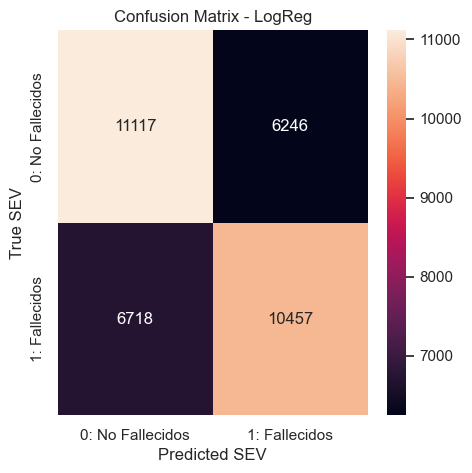

              precision    recall  f1-score   support

           0       0.62      0.64      0.63     17363
           1       0.63      0.61      0.62     17175

    accuracy                           0.62     34538
   macro avg       0.62      0.62      0.62     34538
weighted avg       0.62      0.62      0.62     34538



In [18]:
conf_matrix_LogReg = confusion_matrix(y_test, pred_test2)
plt.figure(figsize=(5, 5))
labels = ['0: No Fallecidos','1: Fallecidos']
sns.heatmap(conf_matrix_LogReg, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion Matrix - LogReg")
plt.ylabel('True SEV')
plt.xlabel('Predicted SEV')
plt.show()
print (classification_report(y_test, pred_test2))

Se puede ver cómo nuestra métrica de referencia ha bajado 10 centésimas. De hecho, aunque las tenemos menos en cuenta, el resto de métricas también se han visto afectadas con la implementación de este modelo. De momento, no parece que vaya a ser el modelo seleccionado. 


Como los resultados en el caso de este modelo no han sido satisfactorios, probamos a ajustar el modelo de otra manera por si el motivo fuese alguna toma de decisión errónea a la hora de la eliminación de alguna de las dos variables descartadas:

In [19]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train_scaled, y_train)

y_pred = classifier.predict(X_test_scaled)

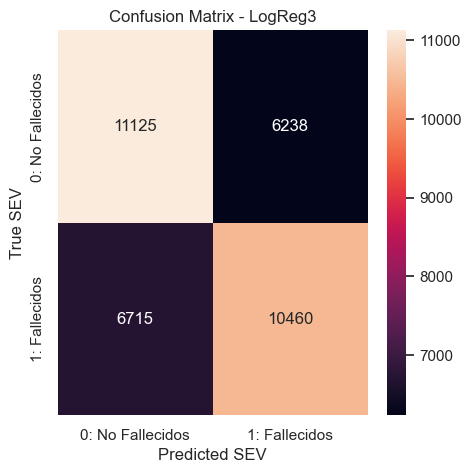

              precision    recall  f1-score   support

           0       0.62      0.64      0.63     17363
           1       0.63      0.61      0.62     17175

    accuracy                           0.62     34538
   macro avg       0.63      0.62      0.62     34538
weighted avg       0.63      0.62      0.62     34538



In [20]:
conf_matrix_LogReg3 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
labels = ['0: No Fallecidos','1: Fallecidos']
sns.heatmap(conf_matrix_LogReg3, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion Matrix - LogReg3")
plt.ylabel('True SEV')
plt.xlabel('Predicted SEV')
plt.show()
print (classification_report(y_test, y_pred))

Se puede comprobar que los resultados en términos de las métricas de evaluación, pero, en especial, en términos de recall, no mejoran. Son prácticamente identicos. 

### **5.3. Árbol de decisión**

En lo siguiente, se ajustará un modelo de Árbol de decisión. Lo primero que se hará será hacer una búsqueda CV análoga a la que hicimos en el caso de KNN. En esta ocasión, el hiperparámetro a optimizar será la máxima profundidad de nuestro árbol:

In [79]:
from sklearn.tree import DecisionTreeClassifier

arbol = DecisionTreeClassifier()

#nuestro hiperparámetro a optimizar será depth. Lo acotamos en un rango de valores entre 1 y 10 para que no se nos vaya de las
#manos
ds = list(range(1,11)) 
h_parameters = {'max_depth':ds} 
cv_simple = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
scoring = make_scorer(recall_score)

cv = GridSearchCV(arbol, h_parameters, cv=cv_simple, n_jobs=-1, scoring=scoring)

cv.fit(X_train, y_train) 

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=42, test_size=0.2, train_size=None),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring=make_scorer(recall_score))

Una vez finalizada la búsqueda, obtenemos que nuestro hiperparámetro óptimo de profundidad es el siguiente:

In [80]:
cv.best_estimator_ 

DecisionTreeClassifier(max_depth=1)

Lo ilustramos de igual manera que lo hacíamos en KNN:

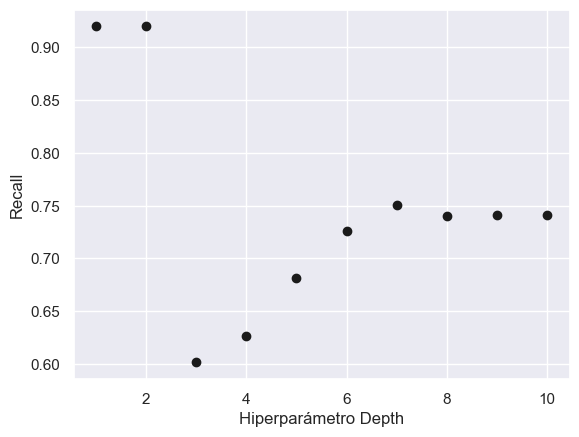

In [81]:
plt.plot(ds, cv.cv_results_['mean_test_score'], 'ok')
plt.xlabel('Hiperparámetro Depth')
plt.ylabel('Recall')
plt.grid(True)

In [83]:
arbol = DecisionTreeClassifier(max_depth=1)
arbol.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=1)

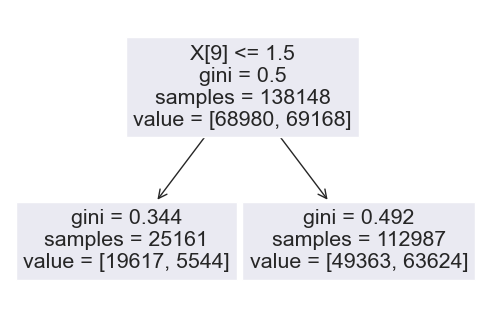

In [84]:
from sklearn.tree import plot_tree

#ploteamos el árbol
plt.figure(figsize=(6, 4))
plot_tree(arbol)
plt.show()

Como se puede observar en la salida previa, con este método ganamos mucho en interpretabilidad. El método que se emplea es muy sencillo: en cada nodo, se escoge uno o varios puntos críticos relacionados con alguna de las variables y, a partir de los mismos, se divide la muestra atendiendo a esos puntos. Es por tanto un método bastante ilustrativo en el que, además, se pueden identificar las variables importantes que realmente se han utilizado para clasificar. 

En este caso, tras el resultado de CV, obteníamos que la profundidas máxima había de ser 1. Por tanto, el único nodo que tenemos es el inicial y, en consecuencia, sólo se usa una de las variables para clasificar. (X[9], que se corresponde con ***C_TRAF***).

En la siguiente salida, hemos querido ilustrar como, en efecto, esta es la única variable relevante para la clasificación cuando usamos este modelo.

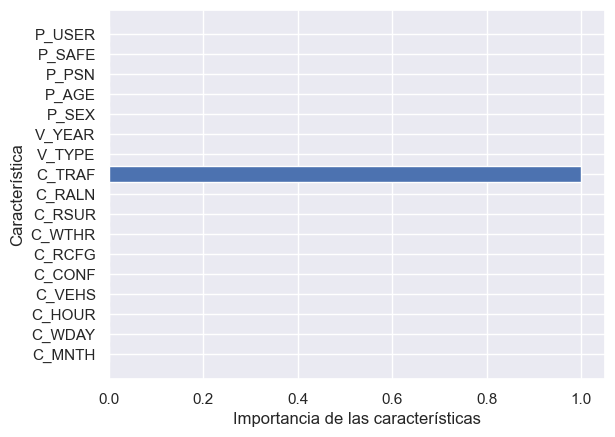

In [85]:
caract = X_train_scaled_df.shape[1] 

plt.barh(range(caract), arbol.feature_importances_) #barras horizontales

plt.yticks(np.arange(caract), X_train_scaled_df.columns) 
plt.xlabel('Importancia de las características')
plt.ylabel('Característica')
plt.show()

A continuación, utilizamos el modelo para predecir sobre test:

In [86]:
y_pred = arbol.predict(X_test)

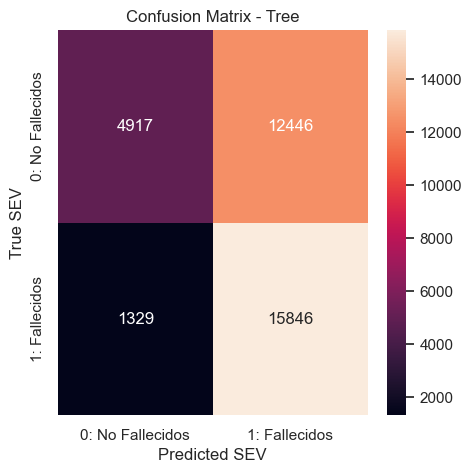

              precision    recall  f1-score   support

           0       0.79      0.28      0.42     17363
           1       0.56      0.92      0.70     17175

    accuracy                           0.60     34538
   macro avg       0.67      0.60      0.56     34538
weighted avg       0.67      0.60      0.56     34538



In [87]:
conf_matrix_Tree = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
labels = ['0: No Fallecidos','1: Fallecidos']
sns.heatmap(conf_matrix_Tree, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion Matrix - Tree")
plt.ylabel('True SEV')
plt.xlabel('Predicted SEV')
plt.show()
print (classification_report(y_test, y_pred))

En este caso, comentamos bastantes cosas:
- En primer lugar, si atendemos al recall para '1', vemos que obtenemos un resultado muy muy bueno: 0.92, es decir, **somos capaces de identificar el 92% de los verdaderos accidentes con fallecimiento**. Teniendo en cuenta que lo que podríamos identificar como nuestro principal objetivo, es esto, es un dato muy positivo.

- Ahora bien, el trade of de obtener este resultado, no es ni mucho menos barato. El pago que estamos haciendo para lograr esta cifra es meter 12446 observaciones de falsos positivos. En este sentido, estamos incurriendo en un coste alto. La autoridad competente habría de valorar si le compensa incurrir en este coste o no. Claro, este suceso, disminuye el recall para '0' al 0.28: **sólo somos capaces de identificar correctamente el 28% de los accidentes que no causan muertes (de los negativos)**.

- **Otras consecuencias**: De nuevo, aunque según lo expuesto previamente no tendría por qué ser de especial relevancia para nosotros, la alta cantidad de falsos positivos obtenidos como resultado del trade of ante minimizar los falsos negativos, hace que la precisión al estimar los accidentes con fallecimiento (precision '1') caiga al 0.56. **NOTA**: esta cifra se calcula haciendo:
                                        Precision1 = TP/(TP+FP)
                                        
    Así, sólo el 56% de predicciones que dicen que el accidente causa fallecidos es cierto. 

- Por su parte, la accuracy también se ve disminuida. 


### **5.4. Random Forest**

Para elegir nuestro mejor modelo Random Forest, haremos de nuevo una búsqueda CV. En esta ocasión, los hiperparámetros que optimizaremos serán: 

- **Máxima Profundidad** de cada árbol del bosque.
-  **Criterio**: determina la métrica utilizada para evaluar la calidad de una división en los árboles. Eligiendo entre "gini" y "entropy" se puede explorar qué métrica funciona mejor para el conjunto de datos.
- **N_estimators**: que determina el número de árboles en el bosque

Hay otros hiperparámetros que podrían haber sido también optimizados a traves de CV. Entre ellos, podemos encontrar: **min_samples_split**, que determina el número mínimo de observaciones necesarias para dividir un nodo interno en dos nodos hijos; **min_samples_leaf**, que especifica el número mínimo de observaciones necesarias en un nodo hoja...

Sin embargo, la optimización de algunos de estos hiperparámetros, sumada a la de los ya escogido, hacía que el número de modelos entrenados en la búsqueda nos condujese a un coste computacional que, quizás, no nos merezca la pena.

Además, al igual que en el resto de búsquedas realizadas hasta ahora, utilizamos CV-simple y no k-fold por motivos computacionales. 

**NOTA: OBVIAMENTE, SI UTILIZÁSEMOS K-FOLD, HARÍAMOS UNA BÚSQUEDA MÁS EXHAUSTIVA Y, PROBABLEMENTE, OBTENDRÍAMOS UNOS RESULTADOS ALGO MEJORES**

In [95]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state = 42)

ds = list(range(1,11))
criterion = ['gini','entropy']
n_s = [100, 200, 300]
h_parameters = {'max_depth': ds, 'criterion': criterion, 'n_estimators': n_s}

cv_simple = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
scoring = make_scorer(recall_score)

cv = GridSearchCV(rf, h_parameters, cv=cv_simple, n_jobs=-1, scoring=scoring)
cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=42, test_size=0.2, train_size=None),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [100, 200, 300]},
             scoring=make_scorer(recall_score))

Una vez finalizada la búsqueda, sacamos los hiperparámetros óptimos obtenidos:

In [96]:
cv.best_estimator_ 

RandomForestClassifier(criterion='entropy', max_depth=2, n_estimators=200,
                       random_state=42)

In [97]:
cv.cv_results_

{'mean_fit_time': array([  9.00077486,  15.92099166,  25.74305964,  13.72214866,
         24.27702832,  35.82894278,  16.09693217,  31.41905594,
         48.12198305,  18.32891417,  36.32205391,  53.65559649,
         20.68004942,  44.58233953,  67.53939152,  24.48426294,
         50.7048316 ,  79.25309706,  27.45616937,  61.09754467,
         83.07116485,  29.81155205,  62.7268424 ,  98.49646187,
         38.91051626,  72.22869086, 101.42557311,  37.02539134,
         67.73937392, 102.97208214,   7.20984864,  15.29566002,
         24.85594654,  12.27189064,  23.85549855,  32.92649055,
         16.41849732,  30.74532127,  45.43522096,  19.50750923,
         39.03127122,  57.73897791,  21.00043011,  47.08337903,
         65.18140531,  25.48857808,  53.48433471,  73.81813693,
         28.68978715,  54.74820447,  85.41872907,  32.61863565,
         63.5825243 ,  85.22580481,  34.51361823,  63.23326111,
         76.45607042,  35.80251837,  53.88699174,  64.13097453]),
 'std_fit_time': arra

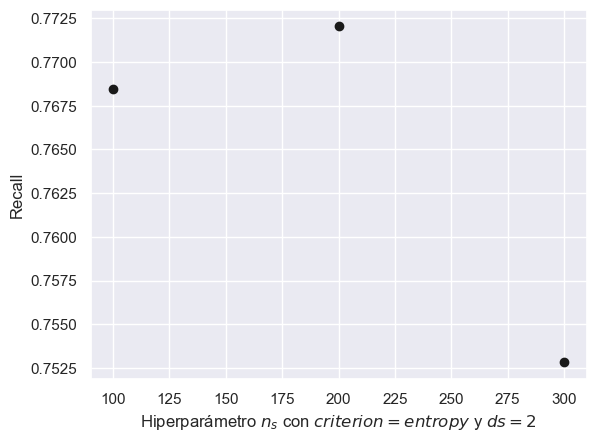

In [98]:
plt.plot(n_s, cv.cv_results_['mean_test_score'][33:36], 'ok')
plt.xlabel('Hiperparámetro $n_s$ con $criterion = entropy$ y $ds = 2$') 
plt.ylabel('Recall') 
plt.grid(True)

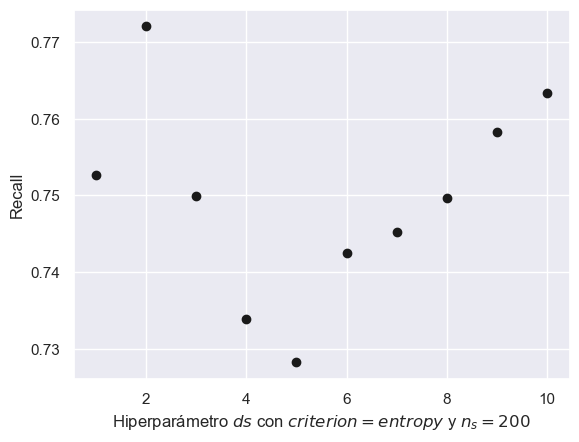

In [101]:
# el 31: porque empiezo a gráficar a partir de la posición trigésimoseungda (incluida)
# len(...) porque lo hago hasta el final del array
# 3 porque lo hago dando saltos de 3 en 3
plt.plot(ds, cv.cv_results_['mean_test_score'][list(range(31, len(cv.cv_results_['mean_test_score']), 3))], 'ok')
plt.xlabel('Hiperparámetro $ds$ con $criterion = entropy$ y $n_s=200$')
plt.ylabel('Recall')
plt.grid(True)

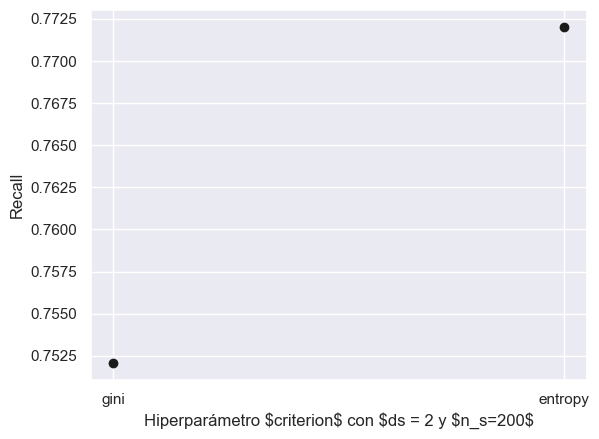

In [102]:
plt.plot(criterion, cv.cv_results_['mean_test_score'][list(range(4, len(cv.cv_results_['mean_test_score']), 30))], 'ok')
plt.xlabel('Hiperparámetro $criterion$ con $ds = 2 y $n_s=200$')
plt.ylabel('Recall')
plt.grid(True)

En las 5 salidas previas, hemos obtenido por orden, respectivamente:

1. Los hiperparámetros óptimos.
2. Un resumen del proceso de CV.
3. 3 gráficas que ilustra el punto 2 (el procedimiento CV Simple). En ellas, se puede ver cuál es cada hiperparámetro óptimo fijando los otros dos en su óptimo.

Una vez ilustrado de manera gráfica lo que estamos haciendo en el ajuste del modelo, vamos a ajustar el modelo con nuestro set de entrenamiento:

In [104]:
rf = RandomForestClassifier(random_state = 42, n_estimators = 200, max_depth = 2, criterion = 'entropy')
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(criterion='entropy', max_depth=2, n_estimators=200,
                       random_state=42)

A continuación, utilizamos el modelo para predecir:

In [105]:
y_pred = rf.predict(X_test_scaled)

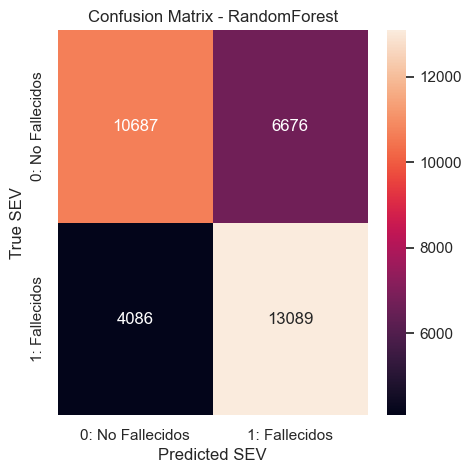

              precision    recall  f1-score   support

           0       0.72      0.62      0.67     17363
           1       0.66      0.76      0.71     17175

    accuracy                           0.69     34538
   macro avg       0.69      0.69      0.69     34538
weighted avg       0.69      0.69      0.69     34538



In [106]:
conf_matrix_rf = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
labels = ['0: No Fallecidos','1: Fallecidos']
sns.heatmap(conf_matrix_rf, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion Matrix - RandomForest")
plt.ylabel('True SEV')
plt.xlabel('Predicted SEV')
plt.show()
print (classification_report(y_test, y_pred))

En esta ocasión, obtenemos unos resultados de evaluación bastante más equilibrados que con el modelo de árboles de decisión. El recall para '1' es mayor que en el caso de KNN, alcanzando el 0.76, aunque es menor que en el caso de árboles de decisión. Sin embargo, que sea menor, no es a cambio de nada. Conseguimos elevar el recall para '0' de 0.28 a 0.62. 

Además, la precisión es ahora también más equilibrada para ambos '0' y '1'. Por último, obtenemos una accuracy muy cercana a la de KNN y mayor a la de árbol. 

__________________________________________________________________

-------------------------------------------------------------------

A continuación, intentaremos aplicar aprendizaje supervisado a nuestro problema de clasificación. 

Desde un primer momento, descartamos  las redes convolucionales, puesto las redes convolucionales son especialmente efectivas cuando se trabaja con datos estructurados en forma de imágenes o datos con una estructura espacial similar, como señales de audio o series temporales. Están especialmente diseñadas para aprovechar las características locales y las relaciones espaciales en los datos. No es nuestro caso y de ahí la decisión.

Así, una opción que puede ser buena para clasificación es la del Perceptrón-Multicapa:

### **5.5. Perceptrón Multicapa**

En este caso, hay también muchísimos hiperparámetros que podrían ser optimizados para encontrar el mejor modelo. Nosotros elegiremos optimizar 2: 

1. **Tamaño de las capas ocultas**: para determinar el número de neuronas en cada capa.
2. **Función de activación**: para determinar la función que se aplica a la salida de cada neurona.


Algún otro hiperparámetro que es también importante es la **tasa de aprendizaje**. En nuestro caso, hemos decidido no entrar a su optimización puesto que recorrer una rejilla para determinar la tasa óptima elevaría bastante nuestro coste computacional, que con los ordenadores que tenemos ya es alto.

In [107]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()

tamaño_capas_ocultas = [(50,), (100,), (50, 50), (100, 100)]
f_act = ['reluc', 'logistic']
h_parameters = {'hidden_layer_sizes': tamaño_capas_ocultas, 'activation': f_act}

cv_simple = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
scoring = make_scorer(recall_score)

cv = GridSearchCV(mlp, h_parameters, cv=cv_simple, scoring = scoring)
cv.fit(X_train_scaled, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_vali

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=42, test_size=0.2, train_size=None),
             estimator=MLPClassifier(),
             param_grid={'activation': ['reluc', 'logistic'],
                         'hidden_layer_sizes': [(50,), (100,), (50, 50),
                                                (100, 100)]},
             scoring=make_scorer(recall_score))

Sacamos los hiperparámetros óptimos:

In [108]:
cv.best_estimator_ 

MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 100))

Entrenamos el modelo de acuerdo a esos hiperparámetros obtenidos:

In [110]:
mlp = MLPClassifier(hidden_layer_sizes = (100,100), activation = 'logistic')
mlp.fit(X_train_scaled, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 100))

Predecimos sobre test:

In [111]:
y_pred = mlp.predict(X_test_scaled)

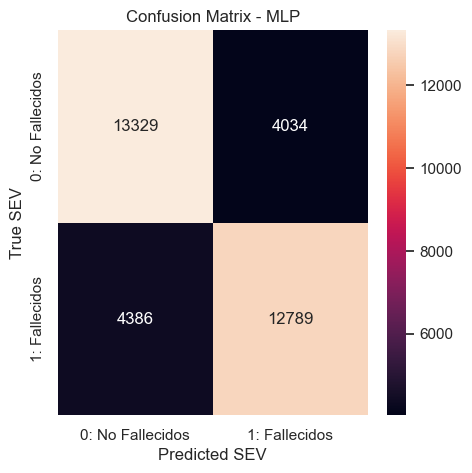

              precision    recall  f1-score   support

           0       0.75      0.77      0.76     17363
           1       0.76      0.74      0.75     17175

    accuracy                           0.76     34538
   macro avg       0.76      0.76      0.76     34538
weighted avg       0.76      0.76      0.76     34538



In [112]:
conf_matrix_mlp = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
labels = ['0: No Fallecidos','1: Fallecidos']
sns.heatmap(conf_matrix_mlp, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion Matrix - MLP")
plt.ylabel('True SEV')
plt.xlabel('Predicted SEV')
plt.show()
print (classification_report(y_test, y_pred))

En este caso, se obtienen unos resultados también equilibrados. Todas las métricas de evaluación son mejor que las obtenidas para KNN. El recall en este caso es algo peor que el obtenido para Random-Forest: 0.74 ahora frente a 0.76 antes, aunque el resto de métricas son mejores. En definitiva: resultados algo mejores que KNN y muy similares a los de Random Forest, con 2 centésimas menos de scoring para el recall '1', (que es el que nos interesa).

## **6. Comparación y selección del modelo óptimo**

En primer lugar, haremos una tabla comparativa entre los diferentes recall de tipo 1 obtenidos:

| MODELO | RECALL |
| :- |:- |
| K-NN |  0.71
|Regresión Logística| 0.61
| Árbol de Decisión | 0.92
| Random Forest | 0.76
| Perceptrón Multicapa | 0.74

Atendiendo a la tabla previa y teniendo en cuenta única y exclusivamente el **Recall de tipo 1**, recomendaríamos a la institución pública correspondiente que se trabajase con el modelo de Árboles de Decisión, ya que es el que mayor porcentaje de observaciones con fallecimiento es capaz de corregir correctamente.

No obstante, y como ya se ha comentado antes, este buen resultado de recall no es gratis, sino que conlleva un deterioro de resultados en el resto de métricas que evalúan el modelo. En este caso, la prioridad por minimizar los falsos negativos, lleva a un elevado número de falsos positivos. Este coste se ve reflejado en el resto de métricas, como ya se dijo en el correspondiente apartado, y podría no compensarle a la institución correspondiente. Sería, por tanto, nuestra obligación exponer la existencia de este coste y que fuesen ellos los que decidiesen o no asumirlo.

En caso de que decidiesen no asumirlo, hemos visto que los dos siguientes modelos que mejor funcionan son Random Forest y Perceptrón Multicapa. El primero tiene un recall de tipo 1 ligeramente superior al segundo que, por su parte, demuestra superioridad en el resto de métricas. En función de cómo valorase el cliente ese 0.02 de diferencia, se acabaría usando uno u otro. Por nuestra parte, recomendaríamos usar el MLP, ya que ese 0.02 de diferencia es muy pequeño en relación a la diferencia en el resto de métricas:

| MODELO | Precision de tipo 1 | Precisión de tipo 0 | Recall de tipo 0 | Accuracy |
| ------ | ------------------- | ------------------- | ---------------- | -------- | 
| Random Forest | 0.66 | 0.72 | 0.62 | 0.69 |
| Perceptrón Multicapa | 0.76 | 0.75 | 0.77 | 0.76 |

En cualquier caso, creemos que la decisión dependería de la disposición a asumir costes del cliente como medio para cumplir su objetivo final: evitar fallecimientos en accidentes.

Por otro lado, es importante tener en cuenta que los costes de más en los que se incurran, no tienen por qué caer en saco roto, sino que podrían servir para solucionar otros problemas 

Por último, nos gustaría hacer un **comentario acerca de los resultados obtenidos**: Creemos que teniendo más capacidad computacional y haciendo búsquedas CV más exhaustivas (optimizando más hiperparámetros, haciendo k-fold, etc.) podríamos haber obtenido resultados algo mejores (tampoco sabemos si mucho mejores, porque seguro que también se pueden mejorar aspectos del preprocessing). Sin embargo, el margen de mejora creemos que no merecía la pena, además de que, en algunos casos, estábamos obteniendo algún *Memory Error*. No obstante, creemos que, pese a no ser excelentísimos resultados en términos de métricas de evaluación, sí son aceptables y, en algún caso y para alguna métrica, incluso buenos.